<a href="https://colab.research.google.com/github/ZenanAH/Team_Energy/blob/master/RNN_on_groups_zen_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras .models import Sequential
from tensorflow.keras .layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras .optimizers import SGD
import math
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
#!pip install tensorflow
Acorn_group="A"
Tariff="Std"

In [48]:
def split_data(filename):
#     print('Input precise path for data including extension')
#     filename = input()
    fulldata = pd.read_csv(filename)
    fulldata['DateTime'] = pd.to_datetime(fulldata['DateTime'])
    train_data = fulldata[(fulldata['DateTime'] >= '2012-01-01') & (fulldata['DateTime'] < '2014-01-01')].reset_index(drop = True)
    validation_data = fulldata[(fulldata['DateTime'] >= '2014-01-01') & (fulldata['DateTime'] < '2014-02-01')].reset_index(drop = True)
    test_data = fulldata[(fulldata['DateTime'] >= '2014-01-01') & (fulldata['DateTime'] < '2014-03-01')].reset_index(drop = True)
    return train_data, validation_data, test_data

def create_data(Acorn_group,Tariff):
    tdata, vdata, testd=split_data(f'https://storage.googleapis.com/energy_usage_prediction_903/df_{Acorn_group}_avg_{Tariff}_v1.csv')
    # add val and train for prophet
    combine_tr_vl=False
    
    if combine_tr_vl==True:
      pdata=pd.concat([tdata,vdata],axis=0).reset_index(drop=True)
    else:
      pdata=tdata

    global_average=False

    if global_average==False:
        # not for global average
        pdata.drop(columns='Unnamed: 0',inplace=True)
        testd.drop(columns='Unnamed: 0',inplace=True)
        vdata.drop(columns='Unnamed: 0',inplace=True)
        
    # group by
    df5=pdata.loc[:,['DateTime','KWH/hh']]
    df5.set_index('DateTime',inplace=True)

    train_df=df5.groupby(by=df5.index).mean()
    train_df=train_df.reset_index()

    test_df=testd.loc[:,['DateTime','KWH/hh']].groupby(by=testd['DateTime']).mean()
    test_df.reset_index(inplace=True)

    val_df=vdata.loc[:,['DateTime','KWH/hh']].groupby(by=vdata['DateTime']).mean()
    val_df.reset_index(inplace=True)
    
    return train_df,test_df,val_df

def plot_predictions(df_plot):
    plt.figure(figsize=(18,6))
    plt.plot(df_plot)
    plt.title('Electricity Consumption Prediction')
    plt.xlabel('Time')
    plt.ylabel('Consumption (kWh/hh)')
    plt.legend()
    plt.show()

def return_mape(test,predicted):
    mape = mean_absolute_percentage_error(test, predicted)
    print("The  mean absolute percenatge error is {}.".format(mape))

In [54]:
acorn_group="A"
tariff='Std'
dataset = pd.read_csv(f'https://storage.googleapis.com/energy_usage_prediction_903/df_{acorn_group}_avg_{tariff}_v1.csv', index_col='DateTime', parse_dates=['DateTime'])
train_df,test_df,val_df=create_data(Acorn_group,Tariff)

In [29]:
df=dataset.groupby(by=dataset.index).mean()
#df.reset_index(inplace=True)
df.drop(columns="Unnamed: 0",inplace=True)
df

,KWH/hh
DateTime,
2012-01-01 00:00:00,0.495875
2012-01-01 00:30:00,0.506625
2012-01-01 01:00:00,0.470625
2012-01-01 01:30:00,0.392375
2012-01-01 02:00:00,0.477750
...,...
2014-02-27 22:00:00,0.598800
2014-02-27 22:30:00,0.571820
2014-02-27 23:00:00,0.511040


In [40]:
test_df[:'2014']

,KWH/hh
DateTime,
2014-02-01 00:00:00,0.42082
2014-02-01 00:30:00,0.36704
2014-02-01 01:00:00,0.29472
2014-02-01 01:30:00,0.29548
2014-02-01 02:00:00,0.26878
...,...
2014-02-27 22:00:00,0.59880
2014-02-27 22:30:00,0.57182
2014-02-27 23:00:00,0.51104


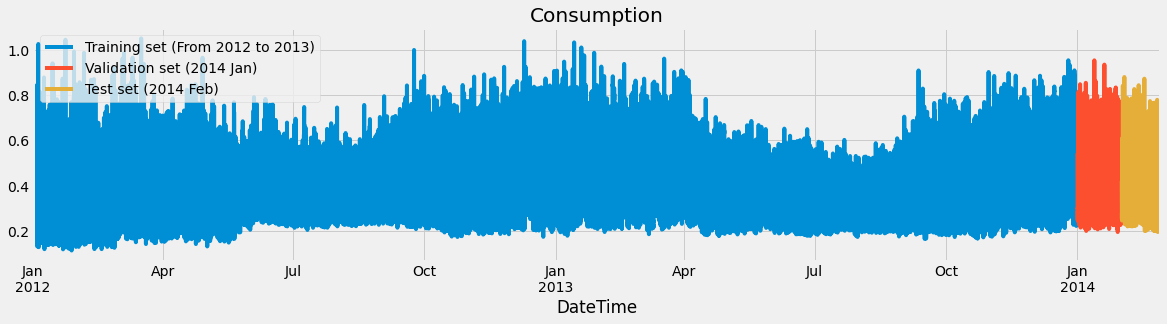

In [43]:
train_df["KWH/hh"][:'2013'].plot(figsize=(18,4),legend=True)
val_df["KWH/hh"]['2014':].plot(figsize=(18,4),legend=True)
test_df["KWH/hh"]['2014':].plot(figsize=(18,4),legend=True)
plt.legend(['Training set (From 2012 to 2013)','Validation set (2014 Jan)','Test set (2014 Feb)'])
plt.title('Consumption')
plt.show()

In [55]:
def prepare_sequences(train_df,test_df,val_df):
  train_df.set_index('DateTime',inplace=True)
  test_df.set_index('DateTime',inplace=True)
  val_df.set_index('DateTime',inplace=True)
  training_set = train_df[:'2013'].loc[:,['KWH/hh']].values
  test_set = test_df['2014':].loc[:,['KWH/hh']].values
  # Scaling the training set
  sc = MinMaxScaler(feature_range=(0,1))
  training_set_scaled = sc.fit_transform(training_set)
  #Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
  # So for each element of training set, we have 60 previous training set elements 
  X_train = []
  y_train = []
  for i in range(60,len(training_set_scaled)):
      X_train.append(training_set_scaled[i-60:i,0])
      y_train.append(training_set_scaled[i,0])
  X_train, y_train = np.array(X_train), np.array(y_train)
  # Reshaping X_train for efficient modelling
  X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
  # Now to get the test set ready in a similar way as the training set.
  # The following has been done so first 60 entries of test set have 60 previous values which is impossible to get 
  dataset_total = pd.concat((train_df["KWH/hh"][:'2013'],test_df["KWH/hh"]['2014':]),axis=0)
  inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
  inputs = inputs.reshape(-1,1)
  inputs  = sc.transform(inputs)
  # Preparing X_test and predicting the prices
  X_test = []
  for i in range(60,len(inputs)):
      X_test.append(inputs[i-60:i,0])
  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

  return  X_train,y_train,X_test,sc,test_set

In [56]:
X_train,y_train,X_test,sc,test_set=prepare_sequences(train_df,test_df,val_df)

In [47]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='MeanAbsolutePercentageError')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
1095/1095 [==============================] - 28s 16ms/step - loss: 303.6510
Epoch 2/50
1095/1095 [==============================] - 19s 17ms/step - loss: 2443.8752
Epoch 3/50
1095/1095 [==============================] - 17s 15ms/step - loss: 2906.2639
Epoch 4/50
1095/1095 [==============================] - 21s 19ms/step - loss: 2240.3245
Epoch 5/50
1095/1095 [==============================] - 20s 19ms/step - loss: 1440.9872
Epoch 6/50
1095/1095 [==============================] - 18s 16ms/step - loss: 2167.7466
Epoch 7/50
1095/1095 [==============================] - 17s 15ms/step - loss: 2256.4685
Epoch 8/50
1095/1095 [==============================] - 17s 15ms/step - loss: 1934.0813
Epoch 9/50
1095/1095 [==============================] - 17s 15ms/step - loss: 759.6458
Epoch 10/50
1095/1095 [==============================] - 17s 15ms/step - loss: 1247.0670
Epoch 11/50
1095/1095 [==============================] - 17s 16ms/step - loss: 942.7213
Epoch 12/50
1095/1095 [==========

In [57]:
#X_train,y_train,X_test,sc,test_set=prepare_sequences(train_df,test_df,val_df)
# prediction
predicted_consumption = regressor.predict(X_test)
predicted_consumption = sc.inverse_transform(predicted_consumption)

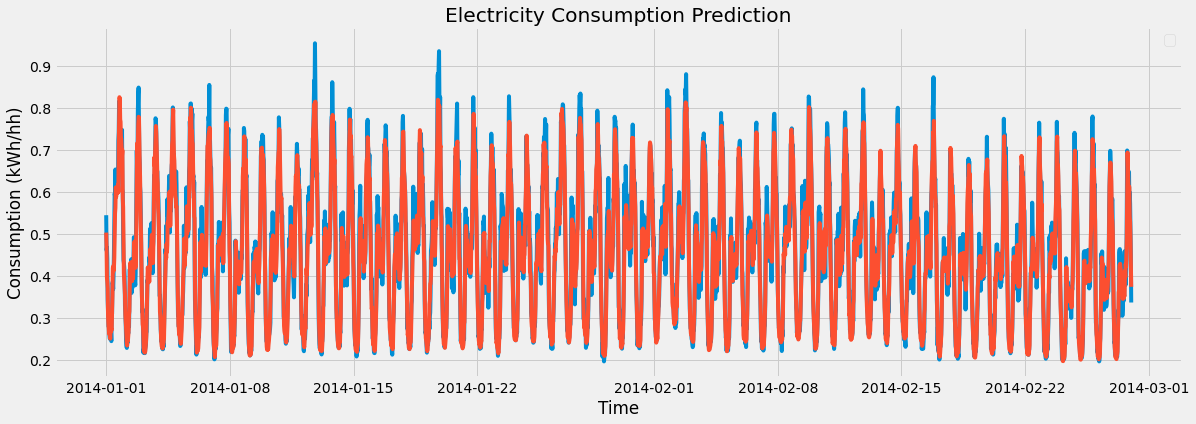

The  mean absolute percenatge error is 0.06530112050177286.


In [58]:

# Visualizing the results for LSTM
df_plot=test_df['2014':].copy()
df_plot.rename(columns={'KWH/hh':'Test'},inplace=True)
df_plot['Predicted']=predicted_consumption
plot_predictions(df_plot)
# Evaluating our model
return_mape(test_set,predicted_consumption)